# N-Body Project 
## Anshak Mallik <br> Computational Astrophysics HS23

Libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import time
import h5py

## Task 1

### 1.1 Step 1
- Preliminarly, **verify the form of the density function $\rho(r)$** by inferring it from the particle distrbution and **compare it with the analytical denstiy function described in the original paper by Hernquist** (from 1990 on Astrophysical Journal available on the web). **Use Poissonian error bars** when comparing the numerical density profile with the analytical expected values.

- Note that the initial conditions are given in a system of units in which $G=1$. **Assume reasonable units of length and mass** for your calculations (nuits of veloctiy and time follow automatically from the assumption) and **discuss your choice**.

#### Units for $G=1$

We are dealing with a globular cluster with the system of units in which the gravitational constant is $G=1$. Thus, it is important to pick the right set of base units. We essentially need to choose a set of new dimensionless units, such that $G=1$ in the new set of units. Let's assume we have the quantity $x$ which has a scale factor $X_0$. This can be converted into an equivalent dimensionless quantity $x' = x/X_0$.

We need to find the appropriate units for the following scale factors: $M_0$ (mass), $R_0$ (length), $T_0$ (time) and $V_0$ (velocity). We will also consider $A_0$ for acceleration.

For a globular cluster, the appropriate scaling factors for the mass and length are: <br>
$M_0 = 1M_{\odot} = 1.989 \cdot 10^{30} \text{kg}$ <br>
$R_0 = 1\text{pc} = 3.086 \cdot 10^{16} \text{m}$

Now, let's assume that the following variable denote the corresponding quantities: $m$ (mass), $r$ (length), $t$ (time), $v$ (velocity) and $a$ (acceleration).

Starting with the gravitational acceleration we get: <br>
$a = G\frac{m}{r^2} \implies a'A_0 = G \cdot m'M_0 \cdot \frac{1}{(r'R_0)^2} \implies a' \frac{R_0}{T_0^2} = G \cdot m'M_0 \cdot \frac{1}{r'^2 R_0^2} \implies a' = G' \frac{m'}{r'^2}$ <br>
Here $a'$, $m'$ and $r'$ are all dimensionless quantities. This means, that $G' = \frac{G M_0 T_0^2}{R_0^3}$ must also be dimensionless. Without loss of generality, let's assume $G'=1$.

From this we we can get the following equation for the scale length of time: <br>
$T_0 = \sqrt{ \frac{R_0^3}{GM_0} } = \sqrt{ \frac{1\text{pc}}{G \cdot 1M_{\odot}}} = 4.705 \cdot 10^{14} \text{s} = 14.92 \text{Myr}$

Similarly, we know that appropriate units for the velocity would be $\text{km/s}$. We get the following for the scale factor: <br>
$V_0 = \frac{R_0}{T_0} = \frac{1\text{pc}}{14.92\text{Myr}} = 0.065 \text{km/s}$.




#### Importing data

In [2]:
filepath = r'data.txt'
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'softening', 'potential']
data = pd.read_csv(filepath, delimiter='\t', names=column_names)

Calculating and storing the distance from the center and velocity of each star in 2 new columns: <br>
$r = \sqrt{x^2 + y^2 + z^2}$ and $v = \sqrt{v_x^2 + v_y^2 + v_z^2}$

In [3]:
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
data['velocity'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)

In [4]:
data

,mass,x,y,z,vx,vy,vz,softening,potential,distance,velocity
0,92.4259,-0.003816,-0.079670,-0.019072,3779.6200,354.734,-73.45010,0.1,0.013022,0.082010,3796.940673
1,92.4259,-0.032298,-0.249461,-0.010890,3250.5900,-674.280,-18.33470,0.1,0.013022,0.251779,3319.838103
2,92.4259,0.067577,-0.810356,-0.006849,2190.8600,199.053,3.86061,0.1,0.013022,0.813198,2199.887393
3,92.4259,-0.152755,0.276704,-0.002704,-2695.1400,-1345.020,105.94600,0.1,0.013022,0.316080,3013.981250
4,92.4259,-0.216623,0.150557,-0.002755,-1811.8900,-2595.570,85.85910,0.1,0.013022,0.263819,3166.591351
...,...,...,...,...,...,...,...,...,...,...,...
50005,92.4259,-0.034591,-0.004853,0.038082,2274.8300,4239.630,-225.45900,0.1,0.013022,0.051675,4816.652969
50006,92.4259,0.100105,-0.006709,-0.025669,-751.0680,-1963.650,113.92200,0.1,0.013022,0.103561,2105.469707
50007,92.4259,0.045565,-0.075928,0.023182,-782.9830,581.401,608.46500,0.1,0.013022,0.091535,1149.486475
50008,92.4259,0.273587,0.567563,0.255294,-20.4115,-212.075,-715.19100,0.1,0.013022,0.679818,746.251031


Plotting the data to look at the what the star cluster looks like.

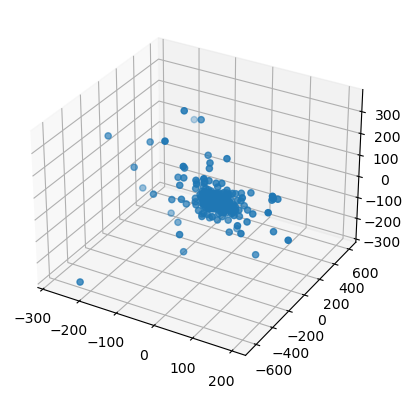

In [5]:
x = data['x'].to_numpy()
y = data['y'].to_numpy()
z = data['z'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

#### Fitting Hernquist profile

**TODO**: _Mention what kind of distribution we expect and why we need to a logarithmic bininng. Also state what an ideal binning number would be and why._

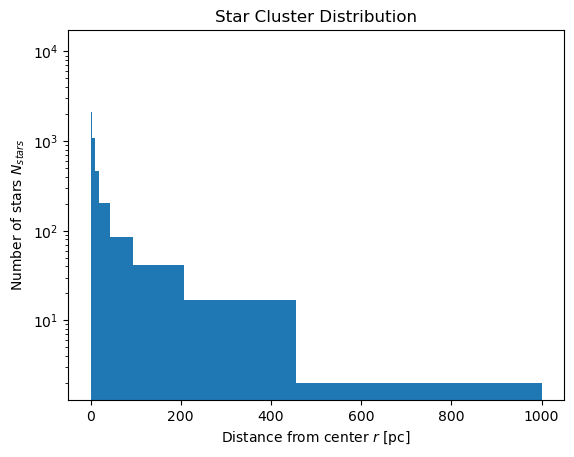

In [6]:
bins = np.logspace(-3.5, 3, num=20) #r ranges from 10e-4.5 to 10e+3
# bins

plt.figure()
plt.title('Star Cluster Distribution')
plt.xlabel(r'Distance from center $r$ [pc]')
plt.ylabel(r'Number of stars $N_{{stars}}$')
hist_data = plt.hist(data['distance'], bins=bins, log=True)

**TODO**: _What do we get from this distribution? Mention how we can use the count per bin and binning edges for fitting_

In [7]:
N_stars = hist_data[0]
np.sum(N_stars) == data.shape[0]
np.sum(N_stars)

50010.0

In [8]:
bin_edges = hist_data[1]
r_left = bin_edges[:-1]
r_right = bin_edges[1:]
bin_edges

array([3.16227766e-04, 6.95192796e-04, 1.52830673e-03, 3.35981829e-03,
       7.38619982e-03, 1.62377674e-02, 3.56969885e-02, 7.84759970e-02,
       1.72521055e-01, 3.79269019e-01, 8.33782223e-01, 1.83298071e+00,
       4.02961132e+00, 8.85866790e+00, 1.94748304e+01, 4.28133240e+01,
       9.41204967e+01, 2.06913808e+02, 4.54877795e+02, 1.00000000e+03])

In [9]:
len(r_right) == len(N_stars)

True

Using mean binning values $r_{\text{avg}}$ as edeges of shells to get shell volumes? NO, using the mean binning values is not a good idea. Instead use outer radius $r_{\text{out}}$.

**TODO**: _Include plot of number of stars dependent on radius?_

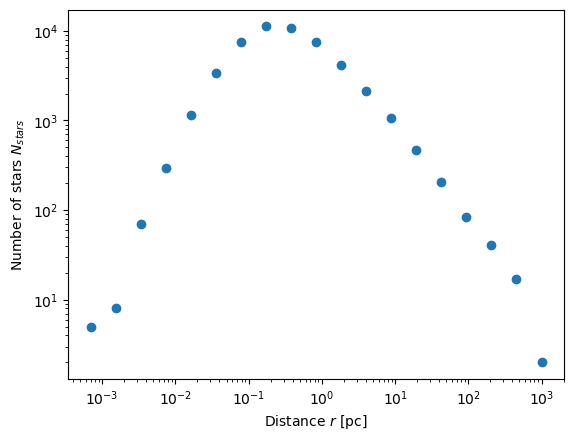

In [10]:
plt.figure()
plt.xlabel(r'Distance $r$ [pc]')
plt.ylabel(r'Number of stars $N_{stars}$')
plt.loglog(r_right, N_stars, 'o')

**TODO**: _Fix description of which formula I used!_ The mass within the volume can be caluclated using the number of stars $N_{\text{stars}}$ within the volume that is created by that outer radius.

Next, we need to get the shell volumes using the outer radii: <br>
$V_{\text{shell}} = \frac{4\pi}{3} \Delta r^3$ <br>
Here, $\Delta r = r_{i+1} - r_{i}$ is the difference between 2 consecutive $r_{\text{out}}$.

In [11]:
# V_shells = []
# for i in range(len(r_outer)-1):
    
#     r_in = r_outer[i]
#     r_out = r_outer[i+1]
    
#     V_shell = 4*np.pi/3 * (r_out**3 - r_in**3)
#     V_shells.append(V_shell)
    
# V_shells = np.array(V_shells)
# V_shells

In [12]:
V_shells = (4/3) * np.pi * (r_right**3 - r_left**3)
V_shells

array([1.27489622e-09, 1.35453622e-08, 1.43915116e-07, 1.52905181e-06,
       1.62456836e-05, 1.72605162e-04, 1.83387432e-03, 1.94843247e-02,
       2.07014682e-01, 2.19946440e+00, 2.33686017e+01, 2.48283876e+02,
       2.63793631e+03, 2.80272247e+04, 2.97780246e+05, 3.16381932e+06,
       3.36145625e+07, 3.57143913e+08, 3.79453919e+09])

Finally, we can get the density of each shell:

$\rho = \frac{m_{\text{shell}}}{V_{\text{shell}}} = \frac{N_{\text{stars}}m_{\text{star}}}{V_{\text{shell}}}$

**TODO**: _Complete sentence_ $\rightarrow$ We know the number of stars $N_{\text{stars}}$ for each me

**TODO**: _Explain how we get total mass and observed densities_

In [13]:
star_mass = data['mass'].values[0]
rho_obs = N_stars*star_mass / V_shells

len(N_stars)
len(V_shells)
total_mass = np.sum(data['mass'].to_numpy())
print('The total mass of all stars is M = {:.2e} M_Sol!'.format(total_mass))

The total mass of all stars is M = 4.62e+06 M_Sol!


In [14]:
def log_Hernquist_profile(r, a):
    log_rho = np.log10(total_mass/(2*np.pi)) + np.log10(a) - np.log10(r) - 3*np.log10(r+a)
    return log_rho

# for i in range(len(a0)):
    
#     popt, pcov = curve_fit(log_Hernquist_profile, r_outer[1:], (rho_obs), maxfev=1500)
#     a_fit = popt[0]
#     a_fit_dev = np.sqrt(pcov[0,0])
    
#     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))

**TODO**: _Mention Hernquist profile and how we will fit it. Don't think we need the logarithmically simplified version_

In [15]:
#Function that defines the Hernquist density profile
def Hernquist_profile(r, a):
    rho = total_mass/(2*np.pi) * (a/r) * (1/(r+a)**3)
    return rho

**TODO**: _Sanity check to see if this value for half-mass radius is correct. Reorder stars in order of increasing distance. Since all stars have the same mass, we can simply assume that the half-mass radius will be around the star which lies in the middle of the newly ordered dataset._

In [16]:
#TODO: check how many stars/mass within half-mass radius
# np.sort(data['distance'])
sort_dist_ind = np.argsort(data['distance'])

sort_dist = data['distance'][sort_dist_ind].to_numpy()
# sort_dist == np.sort(data['distance'])

r_hm = sort_dist[int(len(data['distance'])/2)]
print('The half-mass radius of the star cluster according to the data lies at r_hm = {:.4f} pc'.format(r_hm))

a = r_hm/(1+np.sqrt(2))
print('The scale length of the star cluster according to the data is a = {:.4f}'.format(a))

The half-mass radius of the star cluster according to the data lies at r_hm = 0.1887 pc
The scale length of the star cluster according to the data is a = 0.0782


**Left most bin edges**

In [17]:
# a0 = np.linspace(0, 1, 101)
# for i in range(len(a0)):

#     popt, pcov = curve_fit(Hernquist_profile, r_left, rho_obs, p0=(a0[i]))
#     a_fit = popt[0]
#     a_fit_dev = np.sqrt(pcov[0,0])
    
#     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))
    
popt, pcov = curve_fit(Hernquist_profile, r_left, rho_obs, p0=(0.07))
a_fit = popt[0]
a_fit_dev = np.sqrt(pcov[0,0])
print('Using on the rightmost bin edges: a_fit = {:.3f} +/- {:.3f}'.format(a_fit, a_fit_dev))

Using on the rightmost bin edges: a_fit = 0.085 +/- 0.003


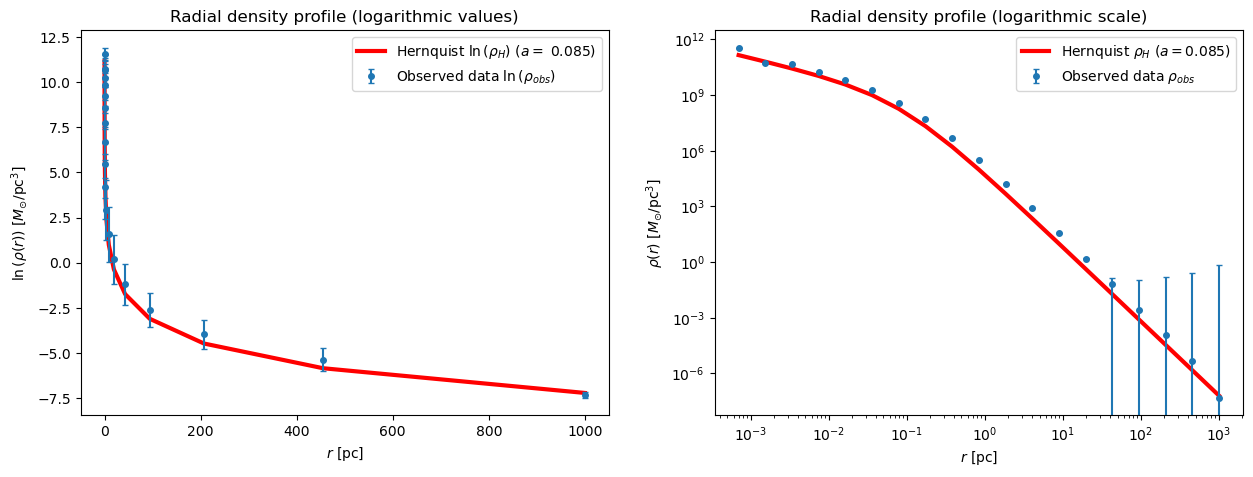

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title(r'Radial density profile (logarithmic values)')
ax[0].set_xlabel(r'$r$ [pc]')
ax[0].set_ylabel(r'$\ln{(\rho(r))}$ [$M_{\odot}$/pc$^3$]')
ax[0].plot(r_right, log_Hernquist_profile(r_right, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
ax[0].errorbar(r_right, np.log10(rho_obs), yerr=np.log10((1/np.sqrt(N_stars))), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
ax[0].legend()

ax[1].set_title(r'Radial density profile (logarithmic scale)')
ax[1].set_xlabel(r'$r$ [pc]')
ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].plot(r_right, Hernquist_profile(r_right, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
ax[1].errorbar(r_right, rho_obs, yerr=1/np.sqrt(N_stars), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
ax[1].legend()

Using obtained scale length, we can figure out what the half-mass radius should be:

$r_{\text{hm}} = (1 + \sqrt{2})a$

In [19]:
r_hm_fit = (1+np.sqrt(2))*a_fit
print('The half-mass radius of the star cluster according to the fit for r_left lies at r_hm_fit = {:.4f} pc'.format(r_hm_fit))

The half-mass radius of the star cluster according to the fit for r_left lies at r_hm_fit = 0.2051 pc


**Right most bin edges**

In [20]:
# # a0 = np.linspace(0, 10, 101)
# # for i in range(len(a0)):

# #     popt, pcov = curve_fit(Hernquist_profile, r_right, rho_obs, p0=(a0[i]))
# #     a_fit = popt[0]
# #     a_fit_dev = np.sqrt(pcov[0,0])
    
# #     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))
    
# popt, pcov = curve_fit(Hernquist_profile, r_right, rho_obs, p0=(0.07))
# a_fit = popt[0]
# a_fit_dev = np.sqrt(pcov[0,0])
# print('Using on the rightmost bin edges: a_fit = {:.3f} +/- {:.3f}'.format(a_fit, a_fit_dev))

In [21]:
# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title(r'Radial density profile (logarithmic values)')
# ax[0].set_xlabel(r'$r$ [pc]')
# ax[0].set_ylabel(r'$\ln{(\rho(r))}$ [$M_{\odot}$/pc$^3$]')
# ax[0].plot(r_left, log_Hernquist_profile(r_left, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
# ax[0].errorbar(r_left, np.log10(rho_obs), yerr=np.log10((1/np.sqrt(N_stars))), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
# ax[0].legend()

# ax[1].set_title(r'Radial density profile (logarithmic scale)')
# ax[1].set_xlabel(r'$r$ [pc]')
# ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

# ax[1].plot(r_left, Hernquist_profile(r_left, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
# ax[1].errorbar(r_left, rho_obs, yerr=1/np.sqrt(N_stars), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
# ax[1].legend()


Using obtained scale length, we can figure out what the half-mass radius should be:

$r_{\text{hm}} = (1 + \sqrt{2})a$

In [22]:
# r_hm_fit = (1+np.sqrt(2))*a_fit
# print('The half-mass radius of the star cluster according to the fit for r_right lies at r_hm_fit = {:.4f} pc'.format(r_hm_fit))

In [23]:
# fig, ax = plt.subplots(2, 2, figsize=(16,12))

# #[0,0]
# ax[0,0].set_title(r'$\ln{(\rho)}$ with $\ln{(\Delta \rho)}$')
# ax[0,0].set_xlabel(r'$r$ [pc]')
# ax[0,0].set_ylabel(r'$\ln{\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[0,0].plot(r_outer, log_Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# # ax[0,0].errorbar(r_outer[1:], np.log(rho_obs), yerr=(1/np.sqrt(np.log(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim (\ln{N_S})^{-0.5}$')
# ax[0,0].errorbar(r_outer[1:], np.log(rho_obs), yerr=np.log((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=3, color='C4', label=r'$\Delta \rho \sim \ln{(N_S^{-0.5})}$')
# ax[0,0].legend()


# #[0,1]
# ax[0,1].set_title(r'$\ln{(\rho)}$ with ${\Delta \rho}$')
# ax[0,1].set_xlabel(r'$r$ [pc]')
# # ax[0,1].set_ylabel(r'$\ln{\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[0,1].plot(r_outer, log_Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# ax[0,1].errorbar(r_outer[1:], np.log(rho_obs), yerr=((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim {(N_S^{-1/2})}$')
# ax[0,1].legend()




# #[1,0]
# ax[1,0].set_title(r'$\rho$ with $\ln{(\Delta \rho)}$')
# ax[1,0].set_xlabel(r'$r$ [pc]')
# ax[1,0].set_ylabel(r'${\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[1,0].set_xscale('log')
# ax[1,0].set_yscale('log')

# ax[1,0].plot(r_outer, Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# # ax[1,0].errorbar(r_outer[1:], (rho_obs), yerr=(1/np.sqrt(np.log(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim (\ln{N_S})^{-0.5}$')
# ax[1,0].errorbar(r_outer[1:], (rho_obs), yerr=np.log((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=3, color='C4', label=r'$\Delta \rho \sim \ln{(N_S^{-0.5})}$')
# ax[1,0].legend()


# #[1,1]
# ax[1,1].set_title(r'$\rho$ with $\Delta \rho$')
# ax[1,1].set_xlabel(r'$r$ [pc]')
# # ax[1,1].set_ylabel(r'${\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[1,1].set_xscale('log')
# ax[1,1].set_yscale('log')

# ax[1,1].plot(r_outer, Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# ax[1,1].errorbar(r_outer[1:], (rho_obs), yerr=((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim {(N_S^{-1/2})}$')
# ax[1,1].legend()

**TODO**: _Explain how good fit is also by using chi squared_

In [24]:
np.log(rho_obs)

array([ 26.61624622,  24.72307041,  24.52894467,  23.60084976,
        22.60854021,  21.31357914,  19.75118966,  17.7922311 ,
        15.38207844,  12.65107065,   9.71260187,   6.67524216,
         3.62780033,   0.43394391,  -2.75469384,  -6.01006646,
        -9.09049063, -12.33402879, -16.83727439])

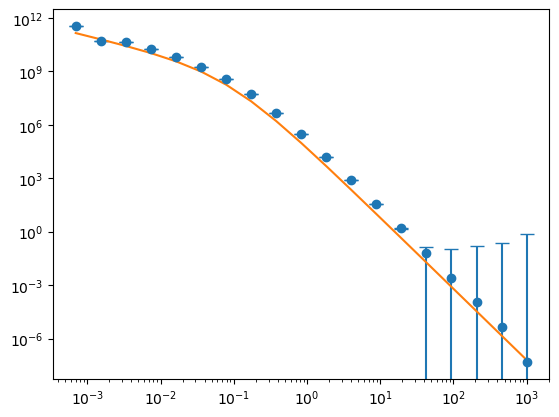

In [25]:
fig = plt.figure()
ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')
ax.errorbar(r_right, rho_obs, yerr=1/np.sqrt(N_stars), fmt='o', capsize=5)
ax.plot(r_right, Hernquist_profile(r_right, a_fit))

### 1.2 Step 2

- **Compute the direct N-Body forces between particles** (note that the array potential[i] is not needed for this purpose). Start by assuming a softening of the order of the mean interparticle separation in the system, then repeat the force calculation by experiment with different values of the softening and discuss your results.

#### Mean Inter-Particle Separation $d$ and Softening $\varepsilon$
Before beginning with the direct force calculation, we need to figure out what we need to use for softening $\varepsilon$. We can assume it to be of the same order of magnitude as the mean inter-particle separation, which is given by:

$d = \bigg( \frac{(4\pi/3)R^3}{N} \bigg) ^{\frac{1}{3}}$

**TODO**; _Justify why we use r_hm_ (Full cluster would be too big and interparticle separation would not accurately represent what we want it to. Also, $r_{\text{hm}}$ is a characteristic length of a clu. <br>
Thus, to determine this we need the number of stars $N$ inside a specific radius $R$. We could use the expected half-mass radius $r_{\text{hm}}$ and the number stars inside the sphere it creates. This is simply half of the total numbers of stars, as all stars have the same mass. So, $N = N_{tot}/2$.

In [26]:
#Total number of stars present
N_stars_tot = int(np.sum(N_stars))
N_stars_tot

50010

In [27]:
r_hm
r_max = np.max(data['distance'].values)
r_max

724.689657812915

In [28]:
#r_hm and all stars
d1 = ((4*np.pi/3)*r_hm**3/N_stars_tot)**(1/3)
d1

0.008258388559901865

In [29]:
#Using the half-mass radius and the number of stars present within it
d = ((4*np.pi/3)*r_hm**3/(N_stars_tot/2))**(1/3)
print('The mean inter-particle separation is \nd = {:.2e}'.format(d))

The mean inter-particle separation is 
d = 1.04e-02


We see that $d$ has an order of magnitude of $10^{-2}$. We can assume the softening is also $\varepsilon \sim 10^{-2}$. For now, let's assume $\varepsilon_{\text{init}} = 1\cdot 10^{-2}$.

In [89]:
#Initialising softening parameter
eps_init = 1e-2
eps_init

0.01

- To check the direct force calculation result and its dependence on the softening choice, **compare it with the analytical force expected based on the application of Newton's second theorem for spherical potentials and plot the result** (use the book "Galactic Dynamics" by Binney and Tremaine as a main reference for the theoretical notions, in particular sec. 2.2 (most recent version of the book) or 2.1 (1987 version)).

#### Direct Force Calculation
We will use the direct summation method to compute the forces. The equation of motion for this also depends on the softening:

$\mathbf{\ddot{r_i}} = -G \sum_{j=1}^N \frac{m_j}{[\mathbf{r_i}-\mathbf{r_j} + \varepsilon^2]^{3/2}} (\mathbf{r_i}-\mathbf{r_j})$

The gravitation softening parameter $\varepsilon$ is introduced for computational efficiency and to enforce numerical smoothness of the model for collisionless fluids. <br>
In the case of a collisionless fluid, we need to avoid the correlation between 2 stars in the cluster. This happens when their own velocities dominate over the forces of gravity. In other words, the square of the mean velocity of the stars $\langle v^2 \rangle$ should be much greater than the circular velocity of an orbit with radius $\varepsilon$:

$\langle v^2 \rangle \propto \frac{GM}{R} \gg \frac{GM}{\varepsilon}$

By picking an ideal softening $\varepsilon$, the relaxation time $t_{\text{relax}}$ can be controlled which in turn can lead to building a collisionless system. We can quickly check if the order of magnitude obtained for $\varepsilon$ is correct, by checking the above mentioned condition:

In [90]:
#Velocity parameter system where G=1
V0 = 0.065 #[km/s]

#Square mean velocity from data
v_squared_mean_data = np.mean(data['velocity'].values**2)
# print('The squared mean velcotiy of stars according to the data is \nv_mean^2 = {:.2e} = {:.2e} km/s'.format(v_squared_mean_data, (V0**2*v_squared_mean_data)))
print('The squared mean velcotiy of stars according to the data is \nv_mean^2 = {:.2e}'.format(v_squared_mean_data))
# print('The mean velcotiy of stars according to the data is \nv_mean = {:.2e}'.format(np.sqrt(v_squared_mean_data)))


The squared mean velcotiy of stars according to the data is 
v_mean^2 = 9.54e+06


Above method seems wrong, probably something with units <br>
**Question**: Why does this not work? Look at it again!

**TODO**: _Explain why I can use velocity of half-mass system instead of directly from data._

**TODO**: _Figure out why it isn't working._

In [91]:
#Squared circular velocity in half-mass radius
m_hm = total_mass/2
v_hm = np.sqrt(m_hm/r_hm)
print('The squared of the mean velocity of stars in the half-mass system is \nv_hm^2 = {:.2e}'.format(v_hm**2))

The squared of the mean velocity of stars in the half-mass system is 
v_hm^2 = 1.22e+07


In [92]:
#Squared circular velocity around an orbit with radius ε
v_circ_squared = total_mass/eps_init #G=1
print('The square of the mean velcotiy of stars according to the data is \nv_circ^2 = {:.2e}'.format(v_circ_squared))

# (v_squared_mean_data/v_circ_squared)**(-1)

The square of the mean velcotiy of stars according to the data is 
v_circ^2 = 4.62e+08


In [93]:
# #Velocity parameter system where G=1
# V0 = 0.065 #[km/s]

# #Mean velocity from data
# v_mean_data = np.mean(data['velocity'].values)
# print('The mean velcotiy of stars according to the data is \nv_mean = {:.2e}'.format(v_mean_data))

In [94]:
star_mass = data['mass'].values[0]
np.sqrt(star_mass/eps_init)

96.1383898346545

**Normal computing**

In [36]:
# def calculate_force(mj, r1, r2, eps):
    
#     x1, y1, z1 = r1
#     x2, y2, z2 = r2
    
#     r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    
#     F12 = (mj/(r12**2 + eps**2)**(3/2)) * (r2-r1)
    
#     return F12


# def calculate_forces(dataset, eps):
    
#     forces = np.zeros((len(dataset), 3))
    
#     for i in range(len(dataset)):
#         for j in range(len(dataset)):
            
#             mj = dataset['mass'][j]
#             ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
#             rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])

#             if i != j:                
#                 Fij = calculate_force(mj, ri, rj, eps)  
#                 forces[i] += Fij
                
#     return forces

**Parallel processing** <br>
**TODO**: _Read up on it to be able to explain what this is._

**TODO**: _Compute forces for 50k stars using parallel computing and explain it._ <br> 
**QUESTION**: Ask Aadi if I can borrow his data if I don't manage to make it.

In [37]:
def calculate_force(mj, r1, r2, eps):
    
    x1, y1, z1 = r1
    x2, y2, z2 = r2
    
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    
    F12 = (mj/(r12**2 + eps**2)**(3/2)) * (r2-r1)
    
    return F12

In [38]:
def calculate_force_parallel_process(dataset, i):
    
    if i % 1000 == 0:
        print(i)
        
    forces = np.zeros(3)
    
    for j in range(len(data)):
        
        mj = dataset['mass'][j]
        ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
        rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])

        if i != j:            
            forces += calculate_force(mj, ri, rj, eps)
        else:
            forces += np.zeros(3)
            
    return forces

In [39]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

In [40]:
def calculate_total_forces_parallel_process(dataset, eps, num_workers=30):
    
    with ProcessPoolExecutor(max_workers = num_workers) as executor:
        nr_stars = range(len(dataset))
        results = executor.map(calculate_force_parallel_process, nr_stars)
        
    forces = np.array(list(results))
    
    return forces

Using the multiprocessing method here

In [41]:
# ##the multiprocessing one
# Started at 14:52

# 3Record start time for processes
# start_time = time.time()
# forces_parallel_proc = calculate_total_force_parallel_process(stars, epsilon)
# #Record end time
# end_time = time.time()
# #Calculate and print the elapsed time
# elapsed_time = end_time - start_time

# #Data to be saved
# forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces_parallel_proc}

# #Save data to a pickle file
# with open('./created_data/forcerrs_50k.pkl', 'wb') as file:
#    pickle.dump(forces_and_time, file)


# print(f"Elapsed time for multiple processes: {elapsed_time} seconds")

Realised I need to access Euler somehow
- Priority for this not that high at the moment, will come back to fix if needed

In [42]:
#Check how many cores are available from euler
import os
import multiprocessing

# Get the number of CPU cores
num_cores = os.cpu_count()

# Alternatively, you can use multiprocessing module to get the number of available CPU cores
num_cores_mp = multiprocessing.cpu_count()

print(f"Number of CPU cores (os.cpu_count()): {num_cores}")
print(f"Number of CPU cores (multiprocessing.cpu_count()): {num_cores_mp}")
# print(f"Number of CPU cores available (len(os.sched_getaffinity(0))): {len(os.sched_getaffinity(0))} ")

Number of CPU cores (os.cpu_count()): 16
Number of CPU cores (multiprocessing.cpu_count()): 16


In [43]:
# #Calculate forces and note how long it takes
# start = time.time()

# subset = 1000
# forces_parallel_process = calculate_total_forces_parallel_processing(data[:subset], eps_init)

# end = time.time()
# elapsed_time = end-start


# #Save the data
# with h5py.File('./subset_forces.h5', 'w') as hf:
#     hf.create_dataset('subset_forces', data=forces_parallel_process)

# print('Elapsed time for parallel processing for {:.0f} stars: {:.3f} s'.format(subset, elapsed_time))

In [44]:
# subset = data.shape[0]

# start = time.time()
# forces = calculate_forces(sort_dist_data[:subset], eps_init)
# # forces
# end = time.time()
# print('Direct force calculation for {:.0f} stars takes {:.3f} s'.format(subset, end-start))

# with h5py.File('./subset_forces.h5', 'w') as hf:
#     hf.create_dataset('subset_forces', data=forces)

**TODO**: _Explain that I'm using the data only within $r_{\text{hm}}$._

In [45]:
# with h5py.File('subset_forces.h5', 'r') as hf:
#     load_array = hf['subset_forces'][:]
# # load_array

In [46]:
data.shape

(50010, 11)

#### Direct Force Calculation and its Dependance on Softening

We can check the result of the direct force calculation and its dependence on the softening parameter by comparing it to the expected solution we get from an analytical approach. This is based on Newton's second theorem for spherical potentials. According to Newton's second theorem, "the gravitational force on a body that lies outside a spherical shell of matter is the same as it would be if all the shell's matter were concentrated into a point center" (Binney & Tremaine, 2007). <br>
Thus, we can compute the force on a star at the edge of a shell using:

$\mathbf{F}(\mathbf{r}) = \frac{GM(r)}{r^2}\mathbf{r}$ 

Here, $M(r)$ is the mass enclosed within a sphere of radius $r$. Let's define a function to calculate the force on a star at the edge of a shell.

In [47]:
def calculate_point_force(i, dataset, eps, indices):
    
    forces = np.zeros(3)
    
    for j in indices:
        
        mj = dataset['mass'][j]
        ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
        rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])
        
        if i != j:
            
            forces += calculate_force(mj, ri, rj, eps)
            
    return forces

$M(r) = 4\pi \int_0^{r} \rho(r') r'^2 \mathop{dr'}$

Using this definition for the mass is probably the correct way.

In [48]:
def force_binney_tremaine(r, a):
    
    #Calculate enclosed mass using the integral provided by Binney & Tremaine
    m, _ = quad(lambda x: 4*np.pi * Hernquist_profile(x, a) * x**2, 0, r)
    
    #Calculate force at distance r for enclosed mass m
    F = m/(r**2)
    
    return F    

$M(r) = M_{\text{tot}} \frac{r^2}{(r+a)^2}$

Using this for testing the half-mass radius will obviously give exactly half, since this is what we indirectly used to obtained it.

In [49]:
def force_hernquist(r, a):
    
    #Calculate enclosed mass using the Hernquist profile
    m = total_mass * (r**2)/(r+a)**2
    
    #Calculate force at distance r for enclosed mass m
    F = m/(r**2)
    
    return F    

Playing around with distances to see which ones correspond to how many stars.

In [50]:
distances = np.linspace(0.01, 0.25, 25)
for distance in distances:
    print('{:.2f} pc -> {:.1e} stars'.format(distance, len(data[data['distance'] <= distance])))
    
# sort_dist_data = data[data['distance'] <= 0.01]
# len(sort_dist_data)

0.01 pc -> 6.7e+02 stars
0.02 pc -> 2.1e+03 stars
0.03 pc -> 3.8e+03 stars
0.04 pc -> 5.7e+03 stars
0.05 pc -> 7.5e+03 stars
0.06 pc -> 9.3e+03 stars
0.07 pc -> 1.1e+04 stars
0.08 pc -> 1.3e+04 stars
0.09 pc -> 1.4e+04 stars
0.10 pc -> 1.6e+04 stars
0.11 pc -> 1.7e+04 stars
0.12 pc -> 1.8e+04 stars
0.13 pc -> 1.9e+04 stars
0.14 pc -> 2.1e+04 stars
0.15 pc -> 2.2e+04 stars
0.16 pc -> 2.3e+04 stars
0.17 pc -> 2.3e+04 stars
0.18 pc -> 2.4e+04 stars
0.19 pc -> 2.5e+04 stars
0.20 pc -> 2.6e+04 stars
0.21 pc -> 2.7e+04 stars
0.22 pc -> 2.7e+04 stars
0.23 pc -> 2.8e+04 stars
0.24 pc -> 2.8e+04 stars
0.25 pc -> 2.9e+04 stars


In [79]:
shell_rads = np.array([0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21])
epsilons = np.linspace(0.003, 0.012, 10)

In [80]:
epsilons

array([0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011,
       0.012])

In [53]:
#Create subsets of the data
data_subsets = []
for rad in shell_rads:
    data_subset = data[data['distance'] <= rad]
    data_subsets.append(data_subset)
    
#Number of subsets
N_subsets = len(data_subsets)

In [54]:
# (data_subsets[0].describe())

Steps for getting the force acting on the furthest star in each sub-shell:

**Finding the furthest star and indexing**
- First, find the star furthest away in the sub-shell (idxmax()).
- Save the index of that star (to be able to access it later).
- Save the index of all stars, to be able to iterate over them later.

In [55]:
#Initialise empty lists
indices_list = []
furthest_star_ind_list = []
furthest_star_r_list = []

for i, data_subset in enumerate(data_subsets):
    
    #Defining which subset to work with
    subset = data_subset
    
    #Saving indices of all stars in this subset
    indices = subset.index.to_list()
    indices_list.append(indices)

    #Finding index of furthest star in this subset
    furthest_star_ind = subset['distance'].idxmax()
    furthest_star_ind_list.append(furthest_star_ind)

    #Finding distance of furthest star in this subset
    furthest_star_r = subset.loc[furthest_star_ind]['distance']
    furthest_star_r_list.append(furthest_star_r)
    
#Convert lists into numpy arrays
indices_array = np.array(indices_list, dtype='object')
furthest_star_ind_array = np.array(furthest_star_ind_list)
furthest_star_r_array = np.array(furthest_star_r_list)

In [56]:
furthest_star_ind_list
np.array(furthest_star_r_list)

array([0.02999711, 0.05999164, 0.08999706, 0.11999942, 0.14999463,
       0.1799986 , 0.20999653])

In [57]:
# np.where(subset.index.to_numpy() == 6782) #gives index of star ID of furthest star (555)
# (subset.index.to_list()[555]) #sanity check, this should yield star ID of furthest star (6782)


**Analytical forces**
- Calculate the force on that star in that subset using Binney & Tremaine.
- Save this force on the furthest star (forces_BT).
- Calculate the force on that star in that subset using Hernquist.
- Save this force on the furthest star (forces_H).

**TODO**: _Figure out units here. Will help with fixing units where I had issues earlier with the velocity._

In [58]:
#Force calculation using Binney & Tremaine
forces_BT = np.zeros(N_subsets)

for i in range(N_subsets):
    
    force_BT = force_binney_tremaine(furthest_star_r_array[i], a_fit)
    forces_BT[i] = (force_BT)
    
forces_BT

array([3.49696873e+08, 2.19955681e+08, 1.50983798e+08, 1.10018551e+08,
       8.37220626e+07, 6.58349784e+07, 5.31251984e+07])

In [59]:
#Force calculation using Hernquist
forces_H = np.zeros(N_subsets)

for i in range(N_subsets):
    force_H = force_hernquist(furthest_star_r_array[i], a_fit)
    forces_H[i] = force_H
    
forces_H

array([3.49696873e+08, 2.19955681e+08, 1.50983798e+08, 1.10018551e+08,
       8.37220626e+07, 6.58349784e+07, 5.31251984e+07])

**Numerical forces**
- Calculate the force on that star in that subset using different softening parameters.
- Save the forces for different parameters but same star in a list.
- Save this list of forces (for different parameters) (forces_num).

In [60]:
N_subsets

7

In [81]:
# %%time
forces_eps_list = []
for i in range(N_subsets):

    
    force_eps_list = []
   
    start = time.time()
    
    for eps in epsilons:
        force_eps_vec = calculate_point_force(furthest_star_ind_array[i], data_subsets[i], eps, indices_array[i])
        force_eps = np.sqrt(force_eps_vec[0]**2 + force_eps_vec[1]**2 + force_eps_vec[2]**2)
        force_eps_list.append(force_eps)
    
    force_eps_array = np.array(force_eps_list)
    
    forces_eps_list.append(force_eps_array)
    
    end = time.time()
    
    print('Subset {:.0f} (r_max = {:.2f} pc): {:.3f} s'.format(i+1, furthest_star_r_array[i], end-start))
    
forces_eps_array = np.array(forces_eps_list, dtype='object')

Subset 1 (r_max = 0.03 pc): 1.460 s
Subset 2 (r_max = 0.06 pc): 3.533 s
Subset 3 (r_max = 0.09 pc): 5.375 s
Subset 4 (r_max = 0.12 pc): 7.569 s
Subset 5 (r_max = 0.15 pc): 8.326 s
Subset 6 (r_max = 0.18 pc): 9.668 s
Subset 7 (r_max = 0.21 pc): 10.273 s


In [73]:
# forces_eps_array[:,0]

array([335522148.6099959, 222909489.5536971, 156756520.57174012,
       113346073.92432275, 86819990.54438882, 70012013.77276601,
       55097171.572198406], dtype=object)

In [84]:
forces_eps_array.shape[1] == len(epsilons)

True

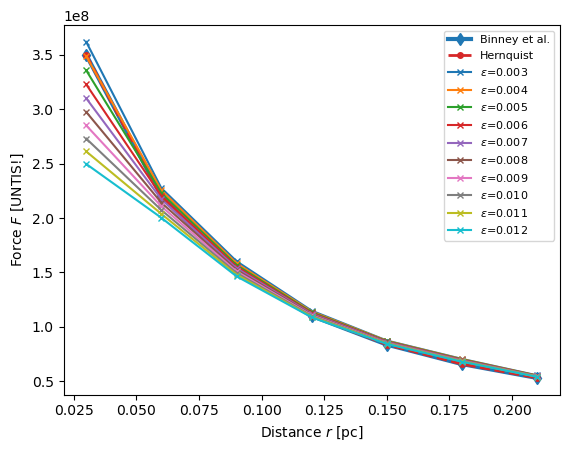

In [123]:
fig = plt.figure()
ax = plt.axes()

ax.set_xlabel(r'Distance $r$ [pc]')
ax.set_ylabel(r'Force $F$ [UNTIS!]')

# ax.set_yscale('log')

# ax.plot(furthest_star_r_array, forces_BT[0]/(furthest_star_r_array)**2/1000)
ax.plot(furthest_star_r_array, forces_BT, 'd-', markersize=6, lw=3, color='C0', label='Binney et al.', zorder=0)
ax.plot(furthest_star_r_array, forces_H, 'o--', markersize=4, lw=2, color='C3', label='Hernquist', zorder=1)

for i in range((forces_eps_array.shape[1])):
    ax.plot(furthest_star_r_array, forces_eps_array[:,i], 'x-', markersize='5', label=r'$\varepsilon$={:.3f}'.format(epsilons[i]), zorder=i+1)

ax.legend(fontsize=8)

# plt.plot(furthest_star_r)

**QUESTION**: Best parameter looks like $\varepsilon = 0.004$. However, thats an order of magnitude smaller than expected. Why?

**TODO**
- _Add title_
- _Add units for force_
- _Explain this plot. Is it good? (Yes, goes with $1/r^2$. Or does it?). And which epsilon looks the bets and why? (0.004 from looking at it). What do we expect? (Closer to 0 should be closer to theory)._

- **Compute the relaxation timescale of the numerical model given the number of particles and the physical crossing timescale** (use the half-mass radius $r_{\text{hm}}$ and the circular velocity computed at the half-mass radius, $v_c = \sqrt{GM(r_{\text{hm}})/r_{\text{hm}}}$ ). Keeping in mind how the relaxation time formula is derived, **do you expect varying the value of the graviational softening to change the relaxation timescale?** In particular, do you expect it to increase or decrease if the softening is increased aobve the interparticle separation? Can you explain why?

**Relaxation Timescale**

The relaxation timescale defines the characteristic time it takes for a system to reach an equilibrium state after initially bein perturbed. Mathematically, it is defined as:

$t_{\text{relax}} = \frac{N_{\text{stars}}}{8\ln{(N_{\text{stars}})}} t_{\text{cross}}$

Here, the crossing time $t_{\text{cross}}$ refers to the time it takes for a particle with velocity $v$ to cross a system of size $R$, assuming a striaght trajectory. It is defined as:

$t_{\text{cross}} = R/v$

In our case, we will use the half-mass radius $R = r_{\text{hm}}$ and its associated circular velocity $v = v_c$. 

In [129]:
#Circular velocity at r_hm_fit
v_c = np.sqrt((total_mass/2) / r_hm_fit)
print('Circular velocity at r_hm_fit: v_c = {:.0f} = {:.0f} km/s'.format(v_c, V0*v_c))

Circular velocity at r_hm_fit: v_c = 3356 = 218 km/s


**TODO**: _Fix units, get them in either s or yr._ <br>
**QUESTION**: How do we even go about it? Simplify pc and km first and then use $T_0$?

In [141]:
#Crossing time
t_cross = r_hm_fit / v_c
print('Crossing time: t_cross = {:.2e} (pc / km/s)'.format(t_cross))

Crossing time: t_cross = 6.11e-05 (pc / km/s)


In [142]:
#Relaxation time
t_relax = (N_stars_tot) / (8*np.log(N_stars_tot)) * t_cross
print('Relaxation time: t_relax = {:.2e} (pc / km/s)'.format(t_relax))

Relaxation time: t_relax = 3.53e-02 (pc / km/s)


## Task 2: tree-code

- **Compute the forces on particles (a subset of them would be fine) using multipole expansion (tree-code)**. For multipole calculation decide on a criterion (distance based) to group particles, eventually **experiment with different orders of that expansion**. Finally, **compare the tree-code result with the direct summation result**, in terms of accuracy as well as computational cost. **Try different softenings** for the direct summation **and different opening angles** for the tree-code.

- Using an appropriate time integrator among those that you have studied and test earlier, **integrate the equation of motions using direct summation for a few systems's corssing timescales** (see definition at Task 1 Step 2). **Repeat the integration with different force softenings** and attempt to **measure the magnitude of numerical relaxation in runs with different softenings, comparing them**. Try different timesteps, justifying the choice.

- OPTIONAL: Attempt to **write a full gravity tree solver scheme** with a time integrator of your choice and evolve the system for at least a few timesteps.

## Appendix

**Guesses for the half-mass radius and scale length**

Verifying the Hernquist profile: $\rho(r) = \frac{M_{\text{tot}}}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}$ <br>
Here, $M_{\text{tot}}$ is the total mass and $a$ is the scale length. 

The Hernquist paper also defines the cumulative mass distribution corresponding to the Hernquist density profile as: $M(r) = M_{\text{tot}} \frac{r^2}{(r+a)^2}$. This means, that at $r=a$ the cumulative mass distribution is a quarter of the total mass: $M(a) = M_{\text{tot}}/4$. From this it follows, that the half-mass radius $r_{\text{hm}}$ and scale length relate in the following way: $r_{\text{hm}} = (1 + \sqrt{2})a$.

In [25]:
#Total mass of all stars
total_mass = np.sum(data['mass'].to_numpy())
print('The total mass of all stars is M = {:.2e} M_Sol!'.format(total_mass))

The total mass of all stars is M = 4.62e+06 M_Sol!


To get the half-mass radius $r_{\text{hm}}$, we can do the following steps:
- Get indices of stars that would sort them by the distance in ascending order (np.argsort)
- Sort the stars by their mass and distance using the indices
- Create array with the cumulative sum of all star mass-es (np.cumsum)
- Set up a condition to get the index where the half-mass is reached
- Get the half-mass radius $r_{\text{hm}}$ using that index

In [57]:
#Getting the indices to sort stars by increasing distances
sort_dist_ind = np.argsort(data['distance'])

#Sort the star masses and distances using these indices
sort_mass = data['mass'][sort_dist_ind]
sort_dist = data['distance'][sort_dist_ind]

#Cumulative sum of mass of whole system
cum_mass = np.cumsum(sort_mass)

#Find index for half-mass and obtain half-mass radius from it
half_mass_ind = np.argmax(cum_mass <= total_mass/2)
half_mass_rad = sort_dist[half_mass_ind]
print('The half-mass radius of the star cluster lies at r_hm = {:.4f} pc!'.format(half_mass_rad))

The half-mass radius of the star cluster lies at r_hm = 0.0820 pc!


Using the half-mass radius $r_{\text{hm}}$, we can make a guess for the scale length:

In [58]:
#Scale length based on dataset
a_data = 1/(1+np.sqrt(2)) * half_mass_rad
print('The scale length based off the dataset is a_data = {:.2f}'.format(a_data))

The scale length based off the dataset is a_data = 0.03


In [28]:
# distances = data['distance']
# # radial_distances

# bins = np.linspace(np.min(distances), np.max(distances), 30)
# # bins
# # np.min(radial_distances)

# hist, _ = np.histogram(distances, bins=bins)
# # hist
# # bin_edges == bins

# shell_inner_rads = bins[:-1]
# shell_outer_rads = bins[1:]
# shell_volumes = (4*np.pi/3) * (shell_outer_rads**3 - shell_inner_rads**3)
# # shell_volumes



Now, to get the observed density profile we can go through the following steps:
- Define the radii we want to work. Their differences will be the shell widths.
- The following steps will iterate through each shell and append the density value obtained to an empy density list.
- To determine which stars are in a specific shell, we can set up a condition and get their specific indices (np.where).
- The total mass in that shell can then be obtained (np.sum)
- Once the total mass is obtained, the shell density can be calculated using the shell volume.

In [29]:
# %%time
# #Defining the radii we want to use to determine the shells
# distances = data['distance']
# bins = np.linspace(np.min(distances), np.max(distances), 10)

# #Initializing empty list of density
# shell_densities = []

# #Iterating over the shells
# for i in range(len(distances)-1):
    
#     #Inner radius
#     shell_inner_rad = distances[i]
    
#     #Outer radius
#     shell_outer_rad = distances[i+1]
    
#     #Indices of stars, which are in shell
#     stars_in_shell_ind = np.where((distances >= shell_inner_rad) & (distances <= shell_outer_rad))[0]
    
#     #Total mass of stars in shell
#     shell_tot_mass = np.sum(data['mass'][stars_in_shell_ind])
    
#     #Volume of shell
#     shell_volume = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)
    
#     #Calculate shell density and append to initialized list
#     shell_density = shell_tot_mass / shell_volume
#     shell_densities.append(shell_density)

The above method is more general but takes too long. Instead, we could take advantage of the fact that all stars have the same mass and use a histogram based approach to get the shell densities:
- Create a historgram with a certain amount of bins. 
- Each bin corresponds to a shell and will have a will have a certain frequency, which corresponds to the number of stars in that shell.
- The total mass of the shell can then be easily obtained.
- The bin widths can be used to obtain their volumes.
- Finally, the shell density can be calculated using the total mass in the shell and volume of the shell.

In [30]:
%%time
#Define shell widths using bins
distances = data['distance']
bins = np.linspace(np.min(distances), np.max(distances), 50)

#Number of stars in shells
N_S, _ = np.histogram(distances, bins=bins)

#Total mass of stars inside shells
star_mass = data['mass'].values[0]
shell_tot_mass = N_S*star_mass

#Volume of shells
shell_outer_rad = bins[1:]
shell_inner_rad = bins[:-1]
shell_vol = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)

#Density of stars in shells
rho_num = shell_tot_mass/shell_vol
# rho_num

Wall time: 0 ns


We can also create a function for the analytical Hernquist density profile dependent on radius $r$ and scale length $a$. This can be used with the outer radii $r_{\text{outer}}$ and the guess for the scale length based on the data $a_{\text{data}}$.

In [31]:
#Function that defines the Hernquist density profile
def Hernquist_profile(r, a):
    rho = total_mass/(2*np.pi) * (a/r) * (1/(r+a)**3)
    return rho

In [32]:
#Fit of Hernquist profile using inner radii and data-based scale length
rho_H = Hernquist_profile(shell_inner_rad, a_data)
# rho_H

Lastly, before we look at the plot and compare the analytical solution to the observed values we need to consider the errors. For this, we will use the Poissonian error, defined as follows: $\epsilon_P = \frac{1}{\sqrt{N_S}} |\rho_{H} - \rho_{\text{num}}|$. $\rho_H$ and $\rho_{\text{num}}$ are the star densities from the Hernquist profile and observed values respectively. $N_S$ is the number of stars per shell.



In [33]:
#Calculating the Poissonian error (to use as error bars in plot)
e_p = np.abs(rho_H - rho_num)/np.sqrt(N_S)
# -> divide by 0 error, increase bin size?

C:\Users\ansha\AppData\Local\Temp\ipykernel_27720\2849040837.py:2: RuntimeWarning: divide by zero encountered in true_divide
  e_p = np.abs(rho_H - rho_num)/np.sqrt(N_S)


In [34]:
e_p

array([1.09444423e+06, 1.63489660e+00, 2.20814391e-01, 6.93872484e-02,
       3.38551892e-02, 1.79418864e-02, 9.16358403e-03, 6.29998176e-03,
       4.02080677e-03, 2.32069697e-03, 2.91979447e-03, 1.39729678e-03,
       9.86159451e-04, 8.32662721e-04, 1.09271901e-03, 4.00925879e-04,
                  inf, 1.90545563e-04, 4.00903408e-04, 3.22861344e-04,
                  inf,            inf, 1.79208878e-04, 1.03038431e-04,
       1.26200987e-04,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf, 1.15484286e-05,
                  inf,            inf,            inf,            inf,
       7.25640029e-06])

Plot

C:\Users\ansha\AppData\Local\Temp\ipykernel_27720\1904561005.py:5: RuntimeWarning: divide by zero encountered in true_divide
  e_p = np.abs(rho - rho_num)/np.sqrt(N_S)


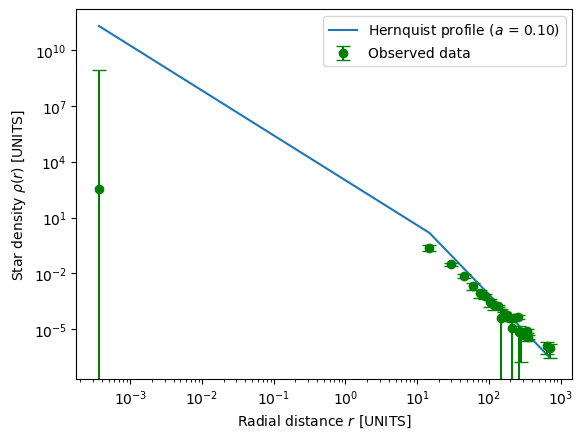

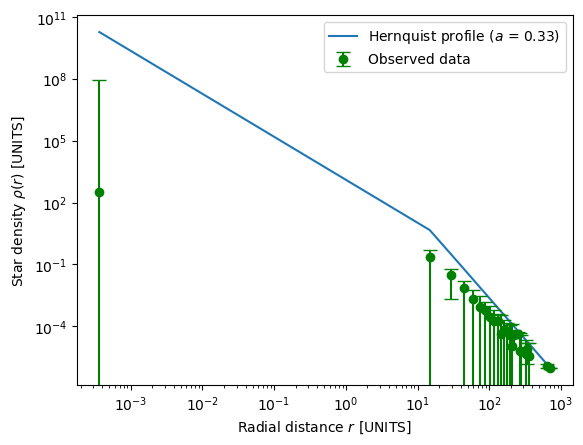

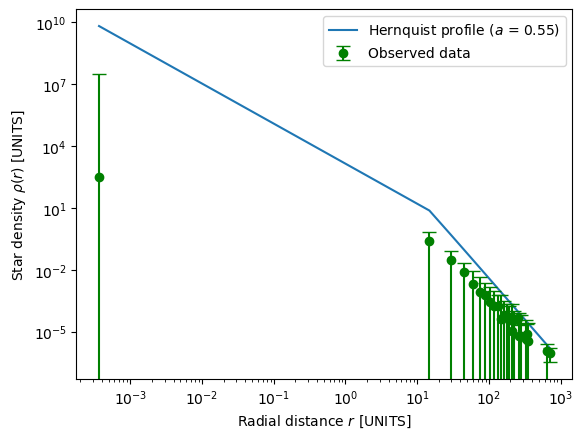

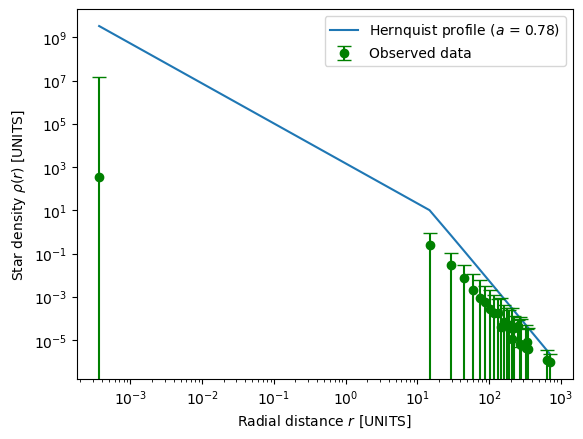

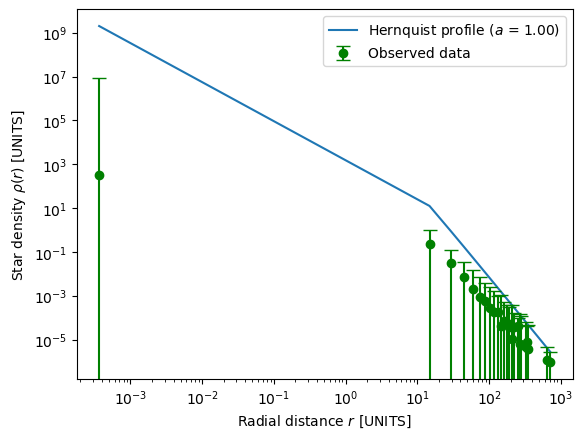

In [35]:
a = np.linspace(0.1, 1, 5)
for i in range(len(a)):
    
    rho = Hernquist_profile(shell_inner_rad, a[i])
    e_p = np.abs(rho - rho_num)/np.sqrt(N_S)
    
    fig, ax = plt.subplots()

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Radial distance $r$ [UNITS]')
    ax.set_ylabel(r'Star density $\rho(r)$ [UNITS]')

    ax.plot(shell_inner_rad, rho, zorder=0, label=r'Hernquist profile ($a$ = {:.2f})'.format(a[i]))
    ax.errorbar(shell_inner_rad, rho_num, yerr=e_p, zorder=1, fmt='o', capsize=5, color='green', label='Observed data')

    ax.legend()
    
    
#     plt.figure()
#     plt.
#     plt.plot(shell_outer_rad, rho, label=r'Hernquist with $a$ = {:.2f}'.format{a[i]})
#     plt.errorbar(shell_outer_rad, rho_num, yerr=e_p, label='Observed')

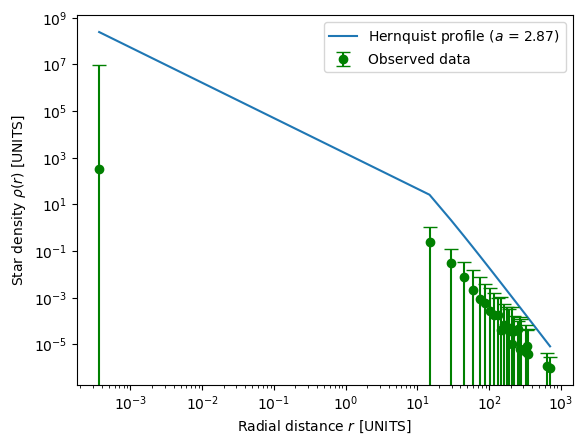

In [36]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Radial distance $r$ [UNITS]')
ax.set_ylabel(r'Star density $\rho(r)$ [UNITS]')

ax.plot(shell_inner_rad, rho_H, zorder=0, label=r'Hernquist profile ($a$ = {:.2f})'.format(a_data))
ax.errorbar(shell_inner_rad, rho_num, yerr=e_p, zorder=1, fmt='o', capsize=5, color='green', label='Observed data')

ax.legend()